## Fine range difference



In [1]:
import sys
sys.path.append("../../../xapres/")
import xapres as xa
import numpy as np
%matplotlib widget

In [97]:
!pip install ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 6.1 MB/s eta 0:00:00a 0:00:01


Extract a short time series somewhere away from the start ofthe times series (which might include test shots etc.)

In [2]:
from_zarr = xa.load.load_zarr().isel(time=slice(300,305)).compute()
from_zarr


<xarray.Dataset> Size: 87MB
Dimensions:          (attenuator_setting_pair: 2, time: 5, chirp_time: 40001,
                      chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 16B -4 -14
    attenuator       (attenuator_setting_pair) float64 16B 5.0 5.0
    burst_number     (time) int64 40B 4 5 6 7 8
  * chirp_num        (chirp_num) int64 160B 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U83 2kB 'ldeo-glaciology/GL_apres_2022/A101/Card...
  * profile_range    (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 40B 2022-05-29T15:06:19 ... 2022-0...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 40B 13.46 13.46 13.45 13.43 13.43
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 64MB ...
    latitude         (time) float64 40B 68.71 68.71 68.71 68.71 68.71
    longitude        (time) float64 40B -49.55 -49.55 -49.55 -49.55 -49.55
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 21MB ...
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 1MB ...
    temperature_1    (time) float64 40B 7.125 4.188 5.953 4.188 5.75
    temperature_2    (time) float64 40B 13.25 11.68 14.62 12.66 10.7

In [3]:
from_zarr.nbytes/1e6

86.747884

Create two staggered time series and align the time dimension to the mid-point of each pair of measurements. 

In [4]:
offset = 1

# extract two time series: 1) the second to the last profiles and 2) the first to the second-to-last profiles
b1_unaligned = from_zarr.isel(time=slice(0,-offset))
b2_unaligned= from_zarr.isel(time=slice(offset,None))

# change the time values to be the midpoints of the consequtive profiles
t1 = b1_unaligned.time.data
t2 = b2_unaligned.time.data
dt = t2-t1
b1 = b1_unaligned
b2 = b2_unaligned
b1['time'] = b1_unaligned.time+dt/2
b2['time'] = b2_unaligned.time-dt/2

The difference in the burst number computed below should be the same as the offset defined above

In [9]:
print(b2.burst_number.data- b1.burst_number.data)
assert np.all(b2.burst_number.data- b1.burst_number.data == offset)

[1 1 1 1]


Define a function that bins the data vertically and computes the coherence between the two staggered time series. 

It computes the depths of the bins as the mean of the depths of all the data points in the bin. As the data points are evenly spaced vertically this is equivelent to the midpoint of bins. 

In [64]:
import xarray as xr
def binned_coherence(b1, b2, bin_size = 20):
    """Calculate the coherence between two time series of profiles in vertical bins. 
    b1 and b2 are xarray DataArrays with dimensions "time" and "profile_range" (and, optionally, others)
    bin_size is the number of samples to include in each bin
    """

    b1_binned = b1.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))
    b2_binned = b2.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))

    bin_depth = b1_binned.profile_range.mean(dim='sample_in_bin').data
    b1_binned = b1_binned.assign_coords(bin_depth=("bin", bin_depth))
    b2_binned = b2_binned.assign_coords(bin_depth=("bin", bin_depth))



    top = (b1_binned * np.conj(b2_binned)).sum(dim="sample_in_bin")

    bottom = np.sqrt( (np.abs(b1_binned)**2).sum(dim="sample_in_bin") * (np.abs(b2_binned)**2).sum(dim="sample_in_bin"))
    c = (top/bottom).rename("coherence")

    c.bin_depth.attrs["units"] = "m"
    c.bin_depth.attrs["long_name"] = "depth to the center of each bin"
    c.bin_depth.attrs["standard_name"] = "bin depth"
    

    phase = xr.apply_ufunc(np.angle, c).rename("phase")
    phase.attrs["units"] = "radians"
    phase.attrs["long_name"] = "coherence phase"


    return xr.merge([c, phase])

c1 = binned_coherence(b1.profile_stacked,b2.profile_stacked,bin_size=20)

In [54]:
c1

<xarray.Dataset> Size: 68kB
Dimensions:     (attenuator_setting_pair: 2, time: 4, bin: 332)
Coordinates:
    AFGain      (attenuator_setting_pair) int64 16B -4 -14
    attenuator  (attenuator_setting_pair) float64 16B 5.0 5.0
    filename    (time) <U83 1kB 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR...
  * time        (time) datetime64[ns] 32B 2022-05-29T15:14:04.500000 ... 2022...
    bin_depth   (bin) float64 3kB 1.998 6.204 10.41 ... 1.39e+03 1.394e+03
Dimensions without coordinates: attenuator_setting_pair, bin
Data variables:
    coherence   (time, bin, attenuator_setting_pair) complex128 42kB (0.99999...
    phase       (time, bin, attenuator_setting_pair) float64 21kB -2.404e-05 ...

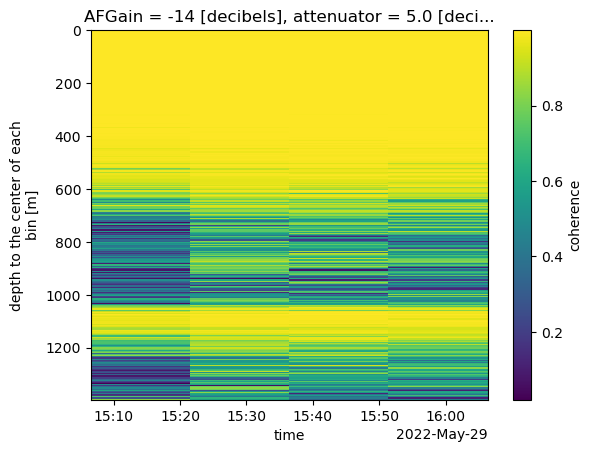

In [55]:
abs(c1.coherence.isel(attenuator_setting_pair=1)).plot(x='time', y='bin_depth', yincrease=False)

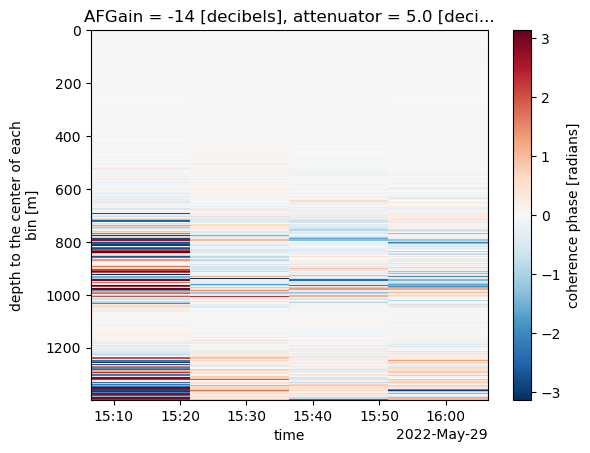

In [56]:
import xarray as xr
c1.phase.isel(attenuator_setting_pair=1).plot(x='time', y='bin_depth', yincrease=False)

## Compare this to the older way of doing the binned coherence calculation

The following defines the bins with a set window size 

In [65]:
import numpy as np
win_cor = 20
step = 20
idxs = np.arange(win_cor//2, b1.profile_stacked.shape[1]-win_cor//2, step).astype(int)
ds = b1.profile_range[idxs]

THe following defines a function to compute the coherence:

In [66]:
def coherence(s1, s2):
    """
    Phase correlation between two elements of the scattering matrix
    Jordan et al. (2019) eq. 13
    Parameters
    ---------
    s1: array
        first acquisition
    s2:
        second acquisition
    Output
    ---------
    c:  array
        phase coherence
    """
    #top = np.einsum('ij,ij->i', s1, np.conj(s2))
    top = (s1 * np.conj(s2)).sum(axis=1)
    bottom = np.sqrt(np.sum(np.abs(s1)**2,axis=1)*np.sum(np.abs(s2)**2,axis=1))
    c = top/bottom


    #top3 = (arr1 * arr2.conj()).sum(dim = 'profile_range')
    #bottom3 = np.sqrt(  (abs(arr1)**2).sum(dim = 'profile_range') * (abs(arr2)**2).sum(dim = 'profile_range')  )
    #co3 = (top3/bottom3).rename('coherence')
    #assert np.allclose(co3, c)
    return c

In [68]:
acq1 = b1.profile_stacked.isel(attenuator_setting_pair=1)
acq2 = b2.profile_stacked.isel(attenuator_setting_pair=1)
c2 = np.empty_like(np.stack([ds.data]*acq1.shape[0])).astype(np.cdouble)
for i, idx in enumerate(idxs):
# index two sub_arrays to compare
    arr1 = acq1[:,idx-win_cor//2:idx+win_cor//2]
    arr2 = acq2[:,idx-win_cor//2:idx+win_cor//2]
    # correlation coefficient between acquisitions
    # amplitude is coherence between acquisitions and phase is the offset
    c2[:,i] = coherence(arr1.data, arr2.data)


In [69]:
c2.shape

(4, 332)

Text(0.5, 1.0, 'Coherence Amplitude')

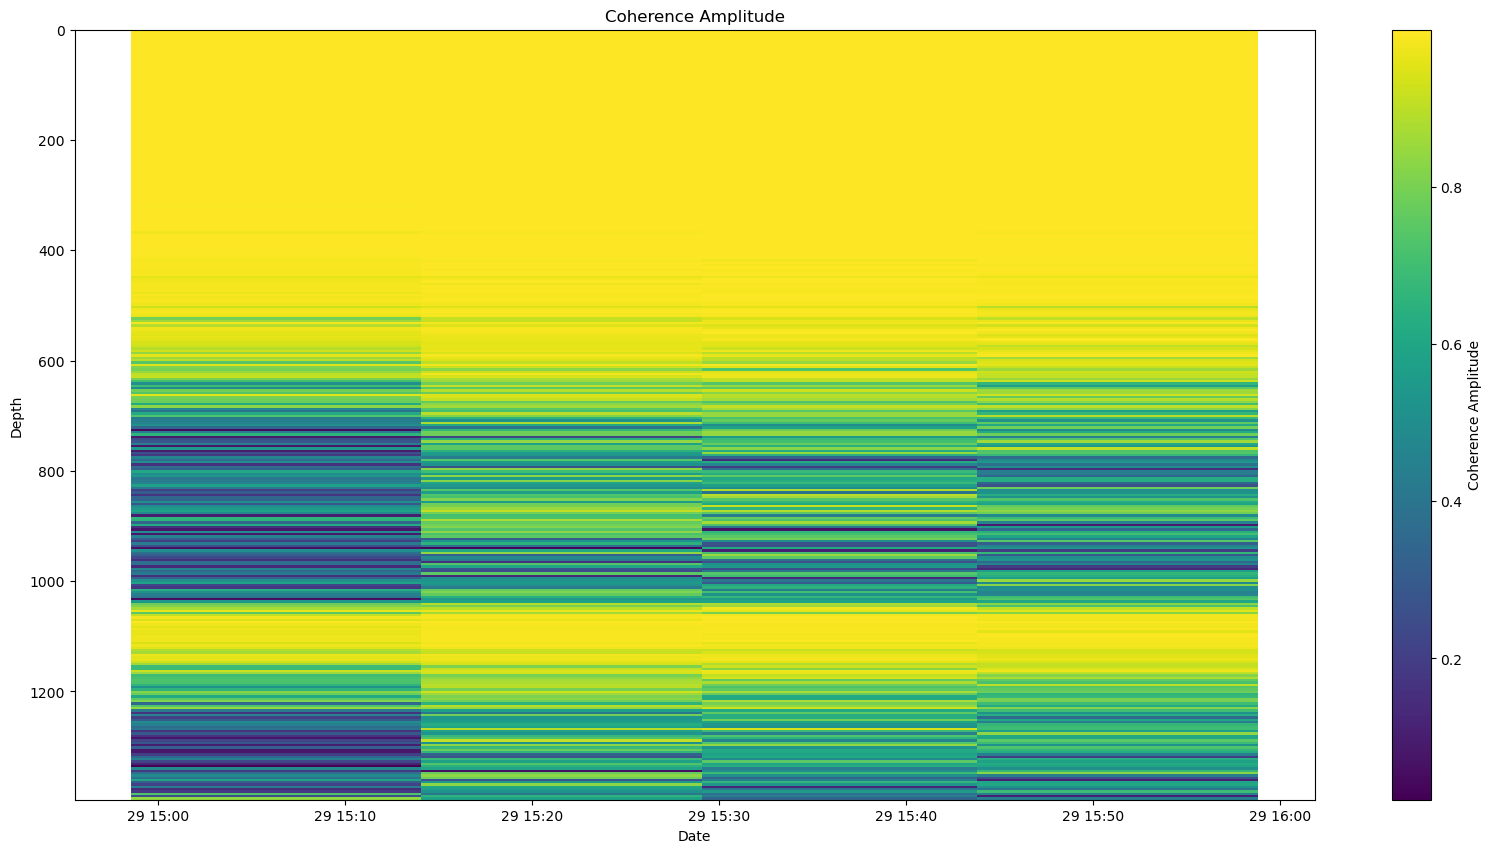

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))

im = plt.pcolormesh(t1,ds.values,abs(c2).transpose())
fig.colorbar(im,label='Coherence Amplitude')
ax.invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Date')
plt.title('Coherence Amplitude')

Text(0.5, 1.0, 'Coherence Phase')

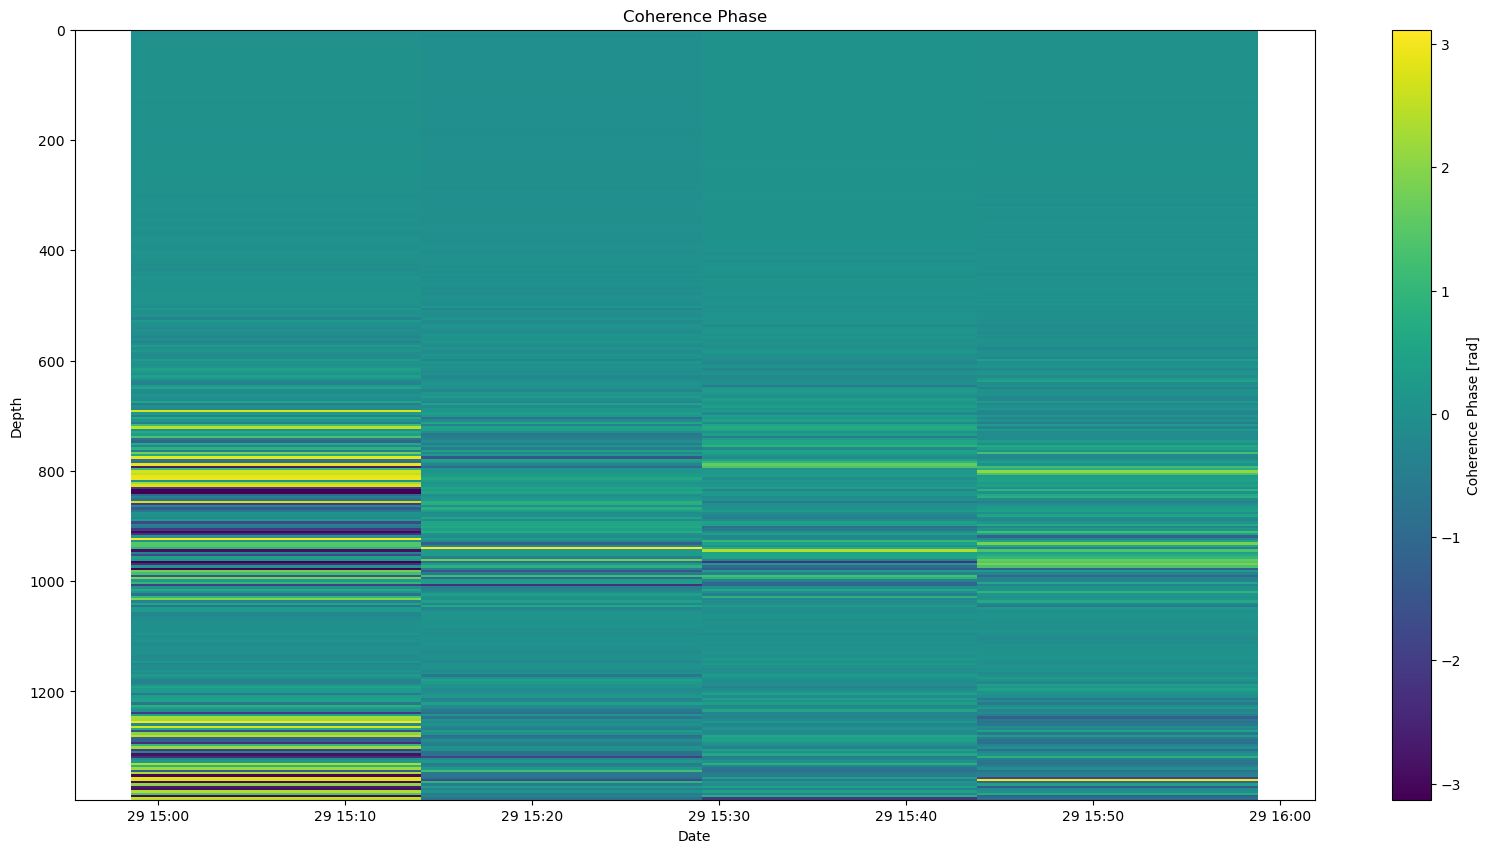

In [71]:
fig, ax = plt.subplots(figsize=(20,10))
phi = -np.angle(c2).astype(float)
im = plt.pcolormesh(t1,ds.values,phi.transpose())
fig.colorbar(im,label='Coherence Phase [rad]')
ax.invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Date')
plt.title('Coherence Phase')

## Compare the two methods

Take a look at the depth of the first bin:


In [72]:
ds.isel(profile_range=0)   # or equivelently ds[0]  or b1.profile_range[idxs[0]]

<xarray.DataArray 'profile_range' ()> Size: 8B
array(2.10289558)
Coordinates:
    profile_range  float64 8B 2.103
Attributes:
    long_name:  depth
    units:      meters

This is slightly different than the depth of th first bin in the xarray c, computed above with the newer method. Why? TLDR: because the value at index 10 is the midpoint of the values between 0 and 19, inclusive.

In [73]:
c1.bin_depth.isel(bin=0)  

<xarray.DataArray 'bin_depth' ()> Size: 8B
array(1.9977508)
Coordinates:
    bin_depth  float64 8B 1.998
Attributes:
    units:          m
    long_name:      depth to the center of each bin
    standard_name:  bin depth

Display the depths of the data points in the first bin in the older method:

In [74]:
b1.profile_range.isel(profile_range=slice(0,20)).data

array([0.        , 0.21028956, 0.42057912, 0.63086867, 0.84115823,
       1.05144779, 1.26173735, 1.4720269 , 1.68231646, 1.89260602,
       2.10289558, 2.31318514, 2.52347469, 2.73376425, 2.94405381,
       3.15434337, 3.36463292, 3.57492248, 3.78521204, 3.9955016 ])

Display the depths of the data points going in the first bin in the xarray `c`

In [75]:
bin_size = 20
b1_binned = b1.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))
b1_binned.profile_range.isel(bin=0).data

array([0.        , 0.21028956, 0.42057912, 0.63086867, 0.84115823,
       1.05144779, 1.26173735, 1.4720269 , 1.68231646, 1.89260602,
       2.10289558, 2.31318514, 2.52347469, 2.73376425, 2.94405381,
       3.15434337, 3.36463292, 3.57492248, 3.78521204, 3.9955016 ])

They are the same. 

The older method takes the 10th value as the bin depth, which is

In [76]:
b1.profile_range.isel(profile_range=10).data

array(2.10289558)

But this is different than the mean of the depths of the data points in the bin, which is what the newer method uses as the bin depth:

In [77]:
b1.profile_range.isel(profile_range=slice(0,20)).data.mean()

np.float64(1.9977507989529077)

The newer method bin depths are consistenly around 10cm shallower than the older method:

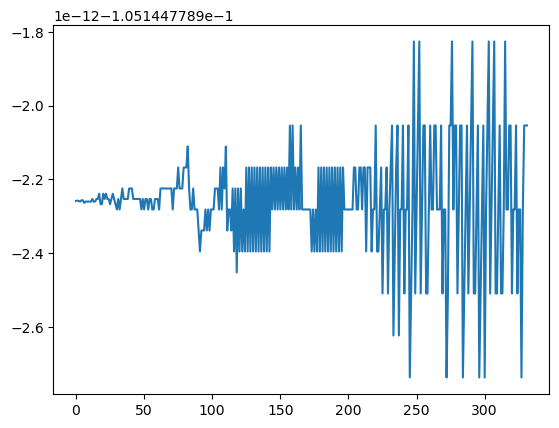

In [78]:
import matplotlib.pyplot as plt
plt.plot(c1.bin_depth.data - ds.data)

In [79]:
c1.bin_depth.data - ds.data


array([-0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10514478,
       -0.10514478, -0.10514478, -0.10514478, -0.10514478, -0.10

## Compare the coherence values

In [91]:
c1.coherence.isel(attenuator_setting_pair = 0, time = 0).data.real

array([ 0.99999866,  0.99883865,  0.99921834,  0.99986805,  0.99896057,
        0.99963134,  0.99994809,  0.99989997,  0.99993174,  0.99990637,
        0.99990491,  0.99987531,  0.99998132,  0.99995771,  0.99992365,
        0.99996083,  0.99998522,  0.99998736,  0.99994333,  0.99987619,
        0.99989012,  0.9999594 ,  0.99987579,  0.99993562,  0.99996442,
        0.99995495,  0.99989945,  0.99987953,  0.99996803,  0.99994955,
        0.99990722,  0.99984642,  0.99993064,  0.99996611,  0.99990711,
        0.99994341,  0.99990345,  0.99970601,  0.99991575,  0.99969169,
        0.9998877 ,  0.99987478,  0.99987655,  0.99947934,  0.99987167,
        0.99962316,  0.99953814,  0.99956176,  0.99975271,  0.99971107,
        0.99956543,  0.9988973 ,  0.99979081,  0.99906215,  0.99962399,
        0.99950064,  0.99965747,  0.99865839,  0.99764135,  0.99945271,
        0.99949284,  0.99871582,  0.99915352,  0.99970806,  0.99987961,
        0.99933767,  0.99845112,  0.99777812,  0.99926452,  0.99

In [93]:
c2[0,:].real

array([ 0.99999986,  0.99884227,  0.99921251,  0.99986773,  0.99897434,
        0.99963867,  0.99994843,  0.99989945,  0.99993188,  0.99990794,
        0.99990549,  0.999875  ,  0.99998177,  0.99995737,  0.99992347,
        0.99996001,  0.99998476,  0.99998796,  0.99994465,  0.99987283,
        0.99989332,  0.99995986,  0.99987804,  0.99993502,  0.99996553,
        0.99995613,  0.99989288,  0.99988796,  0.99997107,  0.99994809,
        0.99991526,  0.99982273,  0.99992434,  0.99996426,  0.99991748,
        0.99993468,  0.99989395,  0.99964952,  0.99991723,  0.99975069,
        0.99990415,  0.9998795 ,  0.99989878,  0.99955585,  0.99987379,
        0.99970189,  0.99947915,  0.99962725,  0.99982341,  0.9996487 ,
        0.99971128,  0.99915588,  0.99986194,  0.99894876,  0.99948445,
        0.9995873 ,  0.99959515,  0.99851429,  0.99798847,  0.99971287,
        0.99930622,  0.99848757,  0.9993777 ,  0.99968479,  0.999781  ,
        0.99950706,  0.99873296,  0.99811226,  0.99895282,  0.99

In [96]:
%matplotlib widget
plt.plot(c2[0,:].real)
plt.plot(c1.coherence.isel(attenuator_setting_pair = 1, time = 0).data.real)


RuntimeError: 'widget is not a recognised GUI loop or backend name

In [88]:
c2[:,0].real

array([0.99999986, 0.99999973, 0.99999947, 0.9999998 ])